In [5]:
import tqdm
import pandas as pd
import numpy as np
import os
from pathlib import Path

import torch
import argparse

import objgraph

import time
import utils

from dn3.configuratron import ExperimentConfig
from dn3.data.dataset import Thinker
from dn3.trainable.processes import StandardClassification
from result_tracking import ThinkerwiseResultTracker

from dn3.transforms.instance import To1020

from dn3_ext import BENDRClassification, LinearHeadBENDR

import matplotlib.pyplot as plt
from scipy import signal

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
# creating dataset, s03

predictions_path = 'predictions/'
experiment_name = 'linear-sleepedf-AASM-pool1-all_data-no-positioning'
# all data 
signal_path = '/dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/all_data_test/s02/ST7241J0-PSG.edf'
annotations_path = '/dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/all_data_test/s02/ST7241JO-Hypnogram.edf'

# signal_path = '/dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/placebo_test/s03/ST7241J0-PSG.edf'
# signal_path = '/dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/temazepam_test/s03/ST7242J0-PSG.edf'
# annotations_path = '/dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/placebo_test/s03/ST7241JO-Hypnogram.edf'
# annotations_path = '/dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/temazepam_test/s03/ST7242JO-Hypnogram.edf'


experiment = ExperimentConfig("configs/testing.yml")
sub = ['s02']

ds_name = 'sleep-edf'
ds_config = experiment.datasets[ds_name]
database_path = experiment.datasets['sleep-edf'].toplevel
ds_config.toplevel = Path(os.path.join(database_path, *sub))

dataset = ds_config.auto_construct_dataset()
dataset.add_transform(To1020())
print(dataset.thinkers)
# per = dataset.thinkers['24'].to_numpy()
# (1356,90,2560) = ilosc skladek, ilosc kanalow, ilosc probek w skladce ( t)

Adding additional configuration entries: dict_keys(['extensions'])
Configuratron found 1 datasets.


Scanning /dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/all_data_test/s02. If there are a lot of files, this may take a while...: 100%|██████████| 1/1 [00:00<00:00, 450.27it/s, extension=.edf]


Creating dataset of 1 Preloaded Epoched recordings from 1 people.


Loading Sleep EDFx Cassette: 100%|██████████| 1/1 [00:00<00:00,  1.20person/s]

>> Sleep EDFx Cassette | DSID: None | 1 people | 1024 trials | 90 channels | 3000 samples/trial | 100.0Hz | 0 transforms
Constructed 1 channel maps
Used by 1 recordings:
EEG (original(new)): FP1(FP1) PZ(PZ) 
EOG (original(new)): HEOGL(VEOGL,VEOGR,HEOGL,HEOGR) 
REF (original(new)): 
EXTRA (original(new)): 
Heuristically Assigned: HEOGL(VEOGL,VEOGR,HEOGL,HEOGR) 
--------------------
Excluded ['EMG submental', 'Marker']
OrderedDict([('24', <dn3.data.dataset.Thinker object at 0x7ff113b42908>)])


In [8]:
model_type = 'linear'

if model_type == utils.MODEL_CHOICES[0]:
    model = BENDRClassification.from_dataset(dataset, multi_gpu='store_true')
else:
    model = LinearHeadBENDR.from_dataset(dataset)

print(model)

model.load(experiment.encoder_weights, include_classifier=True)

model = model.train(False)

# model

Creating LinearHeadBENDR using: 20 channels x 3000 samples at 100.0Hz | 5 targets
Receptive field: 143 samples | Downsampled by 96 | Overlap of 47 samples | 31 encoded samples/trial | 1 pooled
LinearHeadBENDR(
  (classifier): Sequential(
    (0): Flatten()
    (1): Linear(in_features=512, out_features=5, bias=True)
  )
  (encoder): ConvEncoderBENDR(
    (encoder): Sequential(
      (Encoder_0): Sequential(
        (0): Conv1d(20, 512, kernel_size=(3,), stride=(3,), padding=(1,))
        (1): Dropout2d(p=0.1, inplace=False)
        (2): GroupNorm(256, 512, eps=1e-05, affine=True)
        (3): GELU()
      )
      (Encoder_1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): Dropout2d(p=0.1, inplace=False)
        (2): GroupNorm(256, 512, eps=1e-05, affine=True)
        (3): GELU()
      )
      (Encoder_2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): Dropout2d(p=0.1, inplace=False)

In [30]:
model

LinearHeadBENDR(
  (classifier): Sequential(
    (0): Flatten()
    (1): Linear(in_features=512, out_features=5, bias=True)
  )
  (encoder): ConvEncoderBENDR(
    (encoder): Sequential(
      (Encoder_0): Sequential(
        (0): Conv1d(20, 512, kernel_size=(3,), stride=(3,), padding=(1,))
        (1): Dropout2d(p=0.1, inplace=False)
        (2): GroupNorm(256, 512, eps=1e-05, affine=True)
        (3): GELU()
      )
      (Encoder_1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): Dropout2d(p=0.1, inplace=False)
        (2): GroupNorm(256, 512, eps=1e-05, affine=True)
        (3): GELU()
      )
      (Encoder_2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): Dropout2d(p=0.1, inplace=False)
        (2): GroupNorm(256, 512, eps=1e-05, affine=True)
        (3): GELU()
      )
      (Encoder_3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
 

In [32]:
# wszczepiamy hook w enkoder
features_blobs = []

def hook_feature(module, input, output):
    features_blobs.append(output.cpu().data.numpy())

model._modules.get('enc_augment').register_forward_hook(hook_feature)

In [33]:
# bierzemy wagi odpowiadające "werdyktom" softmaxu
params = list(model.parameters())
for param_set in params:
    print(param_set.shape)

weight_softmax = np.squeeze(params[0].cpu().data.numpy())   
print(weight_softmax.shape)

torch.Size([5, 512])
torch.Size([5])
torch.Size([512, 20, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1, 1, 25])
torch.Size([512, 32, 25])
torch.Size([512])
torch.Size([512])
torch.Size([1536, 512, 1])
torch.Size([1536])
torch.Size([512, 1536])
torch.Size([512])
torch.Size([512])
torch.Size([512])
(5, 512)


GPU(s) detected: training and model execution will be performed on GPU.


Predicting: 100%|██████████| 1024/1024 [00:04<00:00, 211.06it/s]


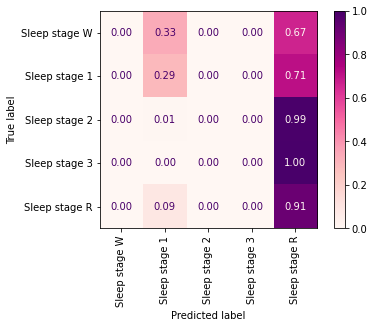

In [34]:
# predictions from model for s02

labels = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']        
classes = [0, 1, 2, 3, 4]


process = StandardClassification(model) 

inputs, outputs = process.predict(dataset)
y_pred = outputs.softmax(dim=1)
y_numpy = y_pred.numpy()

# get tags with highest probability
tags_BENDR = np.argmax(y_numpy, axis=1)
true_tags = inputs[1].numpy()

cmap = 'RdPu'
values_format = ".2f" 


conf_matrix = confusion_matrix(true_tags, tags_BENDR, labels=classes, normalize='true') # true

ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels).plot(
    include_values=True, cmap=cmap, values_format=".2f")

plt.xticks(rotation=90)
plt.show()

In [35]:
for a in features_blobs:
    print(a.shape)

(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 1536, 32)
(1, 15

In [47]:
del features_blobs

In [19]:
# load examplatory signal from subject s02

import mne

raw = mne.io.read_raw(signal_path)

# # PAMIETAC O OFFSECIE!!!! DLA S03 - 17 MINUT
annotations = mne.read_annotations(annotations_path)
# ofset = 19.5 # temazepam
ofset = 17 # placebo

d = annotations.to_data_frame()
print(np.unique(d['description']))
raw.set_annotations(annotations)
raw.anonymize()
print(raw.info['meas_date'])
print(annotations.to_data_frame().shape)
d.head()

['Movement time' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3'
 'Sleep stage 4' 'Sleep stage R' 'Sleep stage W']
2000-01-01 00:00:00+00:00
(102, 3)


,onset,duration,description
0,1970-01-01 00:17:00,150.0,Sleep stage 1
1,1970-01-01 00:19:30,150.0,Sleep stage W
2,1970-01-01 00:22:00,60.0,Sleep stage 1
3,1970-01-01 00:23:00,180.0,Sleep stage 2
4,1970-01-01 00:26:00,30.0,Sleep stage 1


In [20]:
raw_filtered = raw.copy().load_data()
raw_filtered.filter(l_freq=0.5, h_freq=40)

data = raw_filtered.get_data(units='uV')

In [21]:
classes = [0, 1, 2, 3, 4, 5]
fs = int(raw_filtered.info["sfreq"])
print(fs)

# dodajemy offset

signal_FPz = data[0, int(ofset*60)*fs::] #data[4] - data[7]
signal_Pz = data[1, int(ofset*60)*fs::]
signal_EOG = data[2, int(ofset*60)*fs::]


100


In [22]:
# tworzymy maskę z CAMa

def returnCAM(feature_conv, weight_softmax, class_idx):
   
    nc, h = np.squeeze(feature_conv).shape

    output_cam = []
    for idx in class_idx:
        cam = np.dot(weight_softmax[idx], (feature_conv.reshape((nc, h))))
        cam = cam.reshape(h,)
        
        # normalizacja powinna  być do sygnału
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
    return cam

In [23]:
def signal_CMAP(syg, ind, label, fs, features_blobs, channel="Pz"): #, y1=-50, y2=50):
    classes = [0, 1, 2, 3, 4]
    CAM = returnCAM(features_blobs[ind], weight_softmax, [label]) # 3 arguemnt - klasa
    CAM *= y_numpy[ind, label]
    f = signal.resample(CAM, 10 * fs)
    f = signal.resample(f, 30 * fs)

    # plot
    frag = syg[ind*30*fs : (ind + 1)* 30 * fs]

    y1 = np.min(frag) + np.min(frag)*0.1
    y2 = np.max(frag) * 1.1

    # plotujemy składkę z CAMem na wierzchu
    plt.figure(figsize=(30,2), dpi=100)

    plt.plot(frag, 'black')

    for i in range(len(f)):
        plt.fill_betweenx(y=[y1, y2], x1=i, x2=i + 1, color=plt.cm.plasma(f[i]), alpha = 0.5)

    # colorbar    
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma) #, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    plt.colorbar(sm)
    plt.ylim(y1, y2)
    plt.xlim(0, len(f))
    plt.title('Składka 2., sygnał z kanału '+ channel)
    
#     plt.legend()
    plt.show()

In [24]:
# signal_CMAP(signal_FPz, ind, label, fs, features_blobs)

In [25]:
# spektogram

def spektrogram(x, okno, trans , Fs):
    Nx = len(x)
    No = len(okno)
    okno = okno / np.linalg.norm(okno)
    pozycje_okna = np.arange(0, Nx, trans)
    t = pozycje_okna / Fs
    N_trans = len(pozycje_okna)
    f = np.fft.rfftfreq(No, 1 / Fs)
    P = np.zeros((len(f), N_trans))
    z = np.zeros(int(No / 2))
    sig = np.concatenate((z, x, z))
    for i, poz in enumerate(pozycje_okna):  # iterujemy po możliwych pozycjach okna
        s = sig[poz:poz + No]  # pobierz wycinek sygnału o długości okna i rozpoczynający się w aktualnej pozycji okna
        s = s * okno
        S = np.fft.rfft(s)  # oblicz rzeczywistą transformatę zokienkowanego sygnału
        P_tmp = S * S.conj()  # obliczam moc
        P_tmp = P_tmp.real / Fs
        if len(s) % 2 == 0:  # dokładamy moc z ujemnej części widma
            P_tmp[1:-1] *= 2
        else:
            P_tmp[1:] *= 2
        P[:,i] = P_tmp
    return t, f, P


def TFRPlot(TFR, t_mapy, f_mapy, sig, Fs=128, title =''):
    '''
    Funkcja do rysowania map czas-częstość z sygnałem zaprezentowanym poniżej
    TFR - mapa czas-częstość (time-freqyency representation
    t_mapy, f_mapy - wektory reprezentujące osie czasu i częstości
    sig - sygnał do wyrysowania pod mapą (np. ten, z którego powstała mapa)
    Fs - częstość próbkowania sygnału
    title - tytuł do wyświetlenia ponad mapą
    '''
    df = f_mapy[1] - f_mapy[0]
    dt = t_mapy[1] - t_mapy[0]
    t = np.arange(0, len(sig)) / Fs
    
    fig = plt.figure(figsize=(15,10))

    sygAxes = plt.axes([0.05, 0.05, 0.8, 0.1])
    # tworzymy osie do rysowania sygnału
    tfAxes = plt.axes([0.05, 0.15, 0.8, 0.8])  # tworzymy osie do rysowania mapy
    # wykreślam sygnał
    
    sygAxes.plot(t, sig)
    plt.setp(sygAxes, xlim=(t_mapy.min(), t_mapy.max()))


    # wyświetlam mapę
    tfAxes.imshow(TFR,aspect='auto', origin='lower', interpolation='nearest',
                  extent=(t_mapy.min(), t_mapy.max(), f_mapy.min(), f_mapy.max()))
    
    plt.setp(tfAxes, xticklabels=[])
    plt.ylim(0,20)
    
    plt.title(title)

In [26]:
# wybieramy składkę i labelke

label = 4
ind = 207 # 352
print(true_tags[ind])
print(tags_BENDR[ind])
print(f'dla {label} prawdopodobieństwo: '+ str(y_numpy[ind, label]))

4
4
dla 4 prawdopodobieństwo: 0.99968994


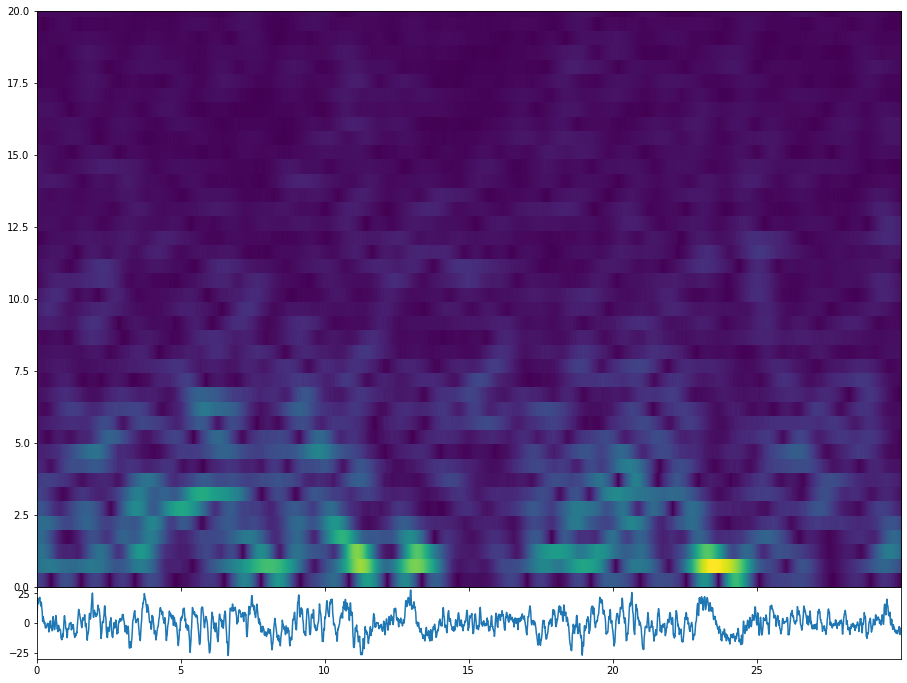

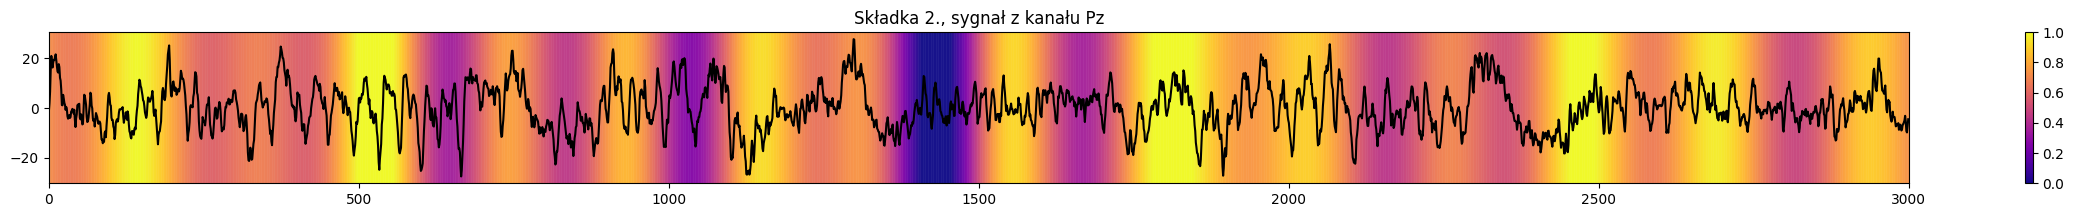

In [330]:
fs = int(raw_filtered.info["sfreq"])

s = signal_Pz[fs * 30 *(ind): fs * 30* (ind + 1)]
h = np.hamming(200)
t_mapy, f_mapy, TFR = spektrogram(s, h, trans=1, Fs=fs)


TFRPlot(np.sqrt(TFR), t_mapy, f_mapy, s, Fs=fs) 

plt.show()

# y1 = np.min(signal_FPz)
# y2 = np.max(signal_FPz)
# print(y1, y2)

# signal_CMAP(signal_FPz, ind, label, fs, features_blobs, "FPz", y1=-100, y2=100)

signal_CMAP(signal_Pz, ind, label, fs, features_blobs, "Pz") #, y1=, y2=50)
# signal_CMAP(signal_EOG, ind, label, fs, features_blobs, "EOG", y1=-300, y2=300)

In [306]:
print(np.where(true_tags==4))

(array([ 196,  197,  198,  199,  200,  201,  202,  203,  204,  205,  206,
        207,  208,  209,  210,  211,  212,  213,  214,  215,  216,  217,
        218,  389,  390,  391,  392,  393,  394,  395,  396,  397,  398,
        399,  400,  401,  402,  403,  404,  405,  406,  407,  408,  409,
        410,  411,  412,  413,  414,  415,  416,  417,  418,  419,  420,
        421,  422,  423,  424,  425,  426,  427,  428,  429,  430,  431,
        432,  433,  434,  435,  573,  574,  575,  576,  577,  578,  579,
        580,  581,  582,  583,  584,  585,  586,  587,  588,  589,  590,
        591,  592,  593,  594,  595,  596,  597,  598,  599,  600,  601,
        602,  603,  604,  605,  606,  607,  608,  609,  611,  612,  614,
        615,  616,  617,  618,  619,  620,  621,  733,  734,  735,  736,
        737,  738,  739,  740,  741,  742,  743,  744,  745,  746,  747,
        748,  749,  750,  751,  752,  753,  754,  755,  756,  757,  758,
        759,  760,  761,  762,  763,  764,  765,  

In [135]:
ofset

17

In [ ]:
###




# ROBOCZE






In [112]:
# CAM i UMAP

del features_blobs

In [17]:
# kolejny hook, tym razem przed samym klasyfikatorem 
# wszczepiamy hook w enkoder
features_blobs_latent = []

def hook_feature(module, input, output):
    features_blobs_latent.append(output.cpu().data.numpy())

model._modules.get('extended_classifier').register_forward_hook(hook_feature)

In [18]:
# predictions from model for s02

process = StandardClassification(model) 

inputs, outputs = process.predict(dataset)
y_pred = outputs.softmax(dim=1)
y_numpy = y_pred.numpy()

# get tags with highest probability
tags_BENDR = np.argmax(y_numpy, axis=1)
true_tags = inputs[1].numpy()

GPU(s) detected: training and model execution will be performed on GPU.


Predicting: 100%|██████████| 1021/1021 [00:04<00:00, 223.42it/s]


In [21]:
print(features_blobs_latent[0][0])

features = np.zeros((len(features_blobs_latent), 512))

for i in range(len(features_blobs_latent)):
    features[i, :] = features_blobs_latent[i][0]

[-9.92756523e-03 -1.02085994e-40  3.35697472e-01 -9.53762904e-02
 -1.90195438e-40  1.91854373e-01  2.42528330e-40 -8.92106146e-02
 -4.21252739e-40 -1.46440029e-01  5.11226952e-01  2.27258861e-01
  2.13376701e-01  1.18248783e-01 -1.46120444e-01 -1.18235514e-01
  3.43784869e-01 -8.11368078e-02  1.76819623e-01  2.85873979e-01
  5.13101935e-01  1.11316711e-01  8.93002450e-02  3.93567592e-01
  5.83226159e-02 -1.41127408e-01  2.32737377e-01 -5.02491519e-02
 -1.25451475e-01 -1.03737436e-01 -1.05871849e-01 -9.12796706e-02
 -9.24567953e-02 -8.72539952e-02 -3.51636261e-02 -1.11997761e-01
  1.94760740e-01 -8.97794142e-02 -1.40723690e-01 -1.86167346e-32
  3.03930014e-01  1.15811422e-01 -1.39483556e-01 -8.75469744e-02
  4.63865846e-01  1.39525086e-01 -1.89308416e-40  2.51871884e-01
 -1.25493050e-01  2.83900887e-01 -1.35802478e-01  4.88496849e-40
  1.45323768e-01 -1.04596019e-01 -1.24554634e-01 -1.12793505e-01
  4.84426469e-01 -1.05570287e-01 -1.38933703e-01 -1.10845789e-01
  2.66306586e-07  1.23726

In [22]:
features.shape

(1021, 512)

In [23]:
# t-SNE https://distill.pub/2016/misread-tsne/

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=100, learning_rate=1000)
tsne_results = tsne.fit_transform(features)

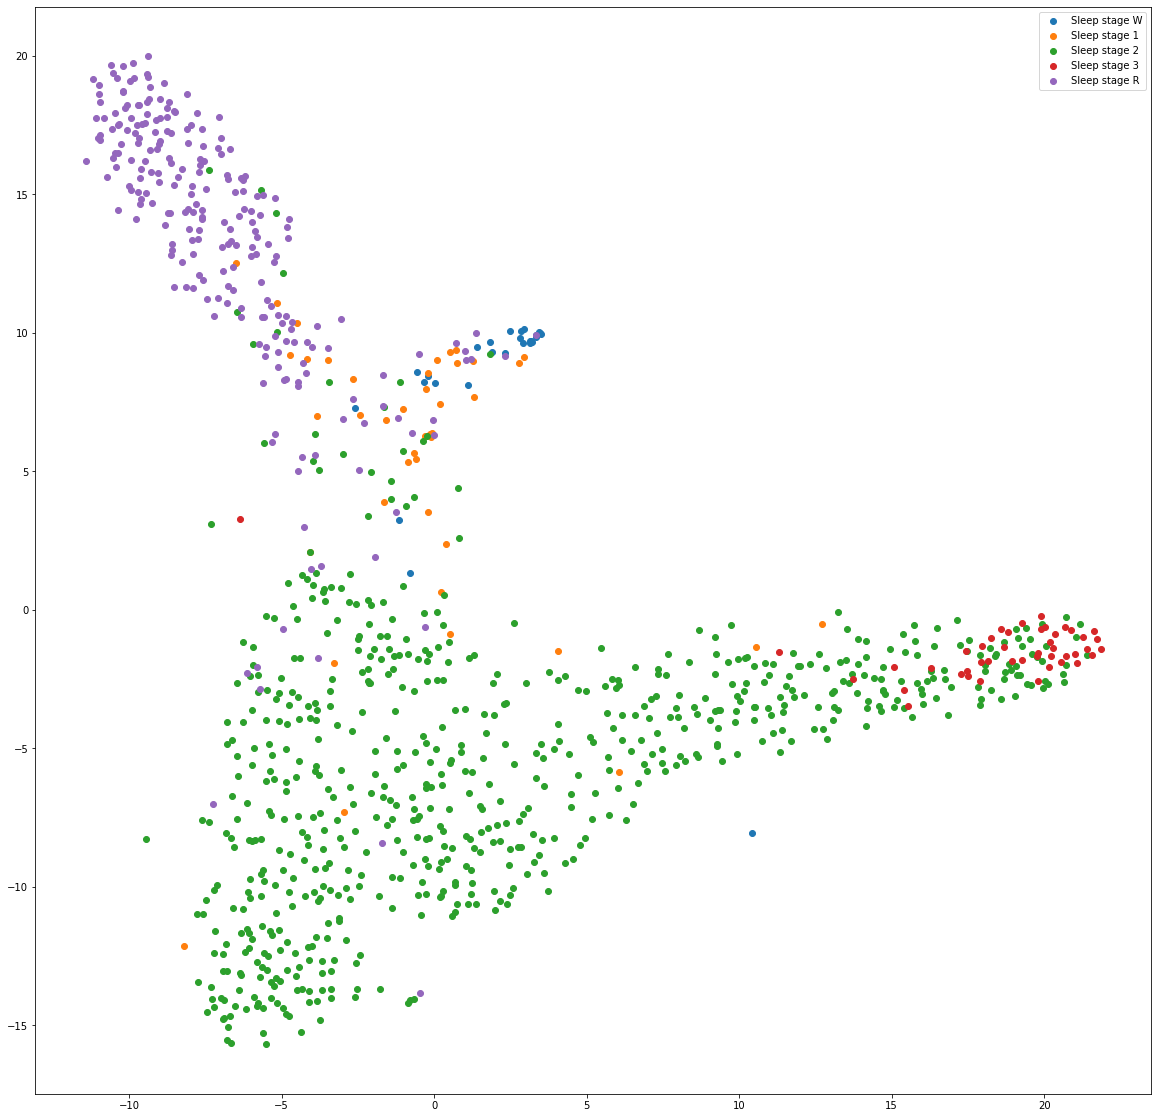

In [24]:
fig = plt.figure(figsize=(20,20))
labels = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']        
classes = [0,1,2,3,4]

for clas in np.unique(true_tags):
    plt.scatter(*tsne_results[true_tags==clas].T, cmap='jet', label=labels[clas]) #, c=true_tags[true_tags==clas]
# ax[1].scatter(*tsne_results.T, cmap='jet') #c=y_train, 
plt.legend()
plt.show()

In [25]:
import umap as umap

from sklearn.preprocessing import StandardScaler

# scaled_features = StandardScaler().fit_transform(features)

reducer = umap.UMAP(n_components=2) #, n_neighbors=40, min_dist=0)
embedding = reducer.fit_transform(features)
embedding.shape

(1021, 2)

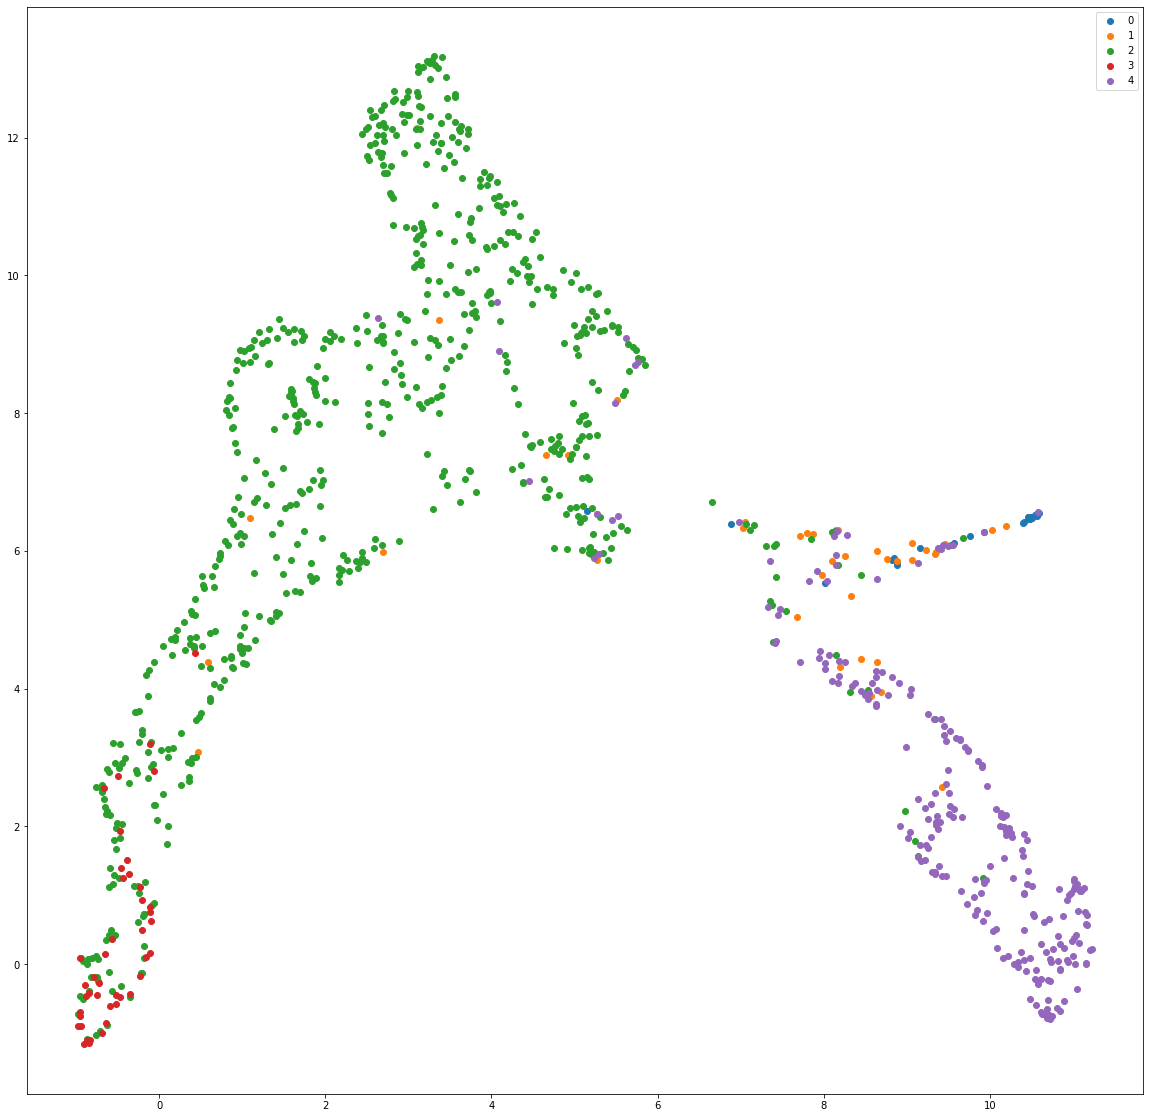

In [26]:
fig = plt.figure(figsize=(20,20))
# labels = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']        

for clas in np.unique(true_tags):
    plt.scatter(embedding[:,0][true_tags==clas], embedding[:,1][true_tags==clas], cmap='jet', label=classes[clas]) #, c=true_tags[true_tags==clas]
# ax[1].scatter(*tsne_results.T, cmap='jet') #c=y_train, 
plt.legend()
plt.show()